# Sloan Digital Sky Survey Classification
## Classification of Galaxies, Stars and Quasars based on the RD14 from the SDSS

![title](https://qph.fs.quoracdn.net/main-qimg-27d05371e3ca96def06caed28a1ee135.webp)

you can see short explanation [here](https://www.quora.com/What-is-the-difference-between-a-quasar-and-a-star)

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

### About the notebook

Out goal is to classify observations of space to be either stars, galaxies or quasars. We will try to have a complete cycle of the data science workflow including data analysis, training models, scoring, cross validating and getting final results.

We are using data from the Sloan Digital Sky Survey (**Release 14**). 

### About the SDSS

The Sloan Digital Sky Survey is a project which offers public data of space observations. Observations have been made since 1998 and have been made accessible to everyone who is interested. 

For this purpose a special 2.5 m diameter telescope was built at the Apache Point Observatory in New Mexico, USA. The telescope uses a camera of 30 CCD-Chips with 2048x2048 image points each. The chips are ordered in 5 rows with 6 chips in each row. Each row observes the space through different optical filters (u, g, r, i, z) at wavelengths of approximately 354, 476, 628, 769, 925 nm.

The telescope covers around one quarter of the earth's sky - therefore focuses on the northern part of the sky.

**For more information about this awesome project - please visit their website:**

http://www.sdss.org/

![alt text](http://www.fingerprintdigitalmedia.com/wp-content/uploads/2014/08/sdss1.jpg)

### Importing Libraries

In [2]:
# data manipulations
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
from matplotlib import style
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting
import seaborn as sns
sns.set_style('whitegrid')

# model building, scoring and data transformations
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# time and warnings
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

# plot formatting
SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

### Feature Description

#### View "PhotoObj"
* objid = Object Identifier
* ra = J2000 Right Ascension (r-band)
* dec = J2000 Declination (r-band)

Right ascension (abbreviated RA) is the angular distance measured eastward along the celestial equator from the Sun at the March equinox to the hour circle of the point above the earth in question. When paired with declination (abbreviated dec), these astronomical coordinates specify the direction of a point on the celestial sphere (traditionally called in English the skies or the sky) in the equatorial coordinate system.

Source: https://en.wikipedia.org/wiki/Right_ascension

* u = better of DeV/Exp magnitude fit
* g = better of DeV/Exp magnitude fit
* r = better of DeV/Exp magnitude fit
* i = better of DeV/Exp magnitude fit
* z = better of DeV/Exp magnitude fit

The Thuan-Gunn astronomic magnitude system. u, g, r, i, z represent the response of the 5 bands of the telescope.

Further education: https://www.astro.umd.edu/~ssm/ASTR620/mags.html

* run = Run Number
* rereun = Rerun Number
* camcol = Camera column
* field = Field number

Run, rerun, camcol and field are features which describe a field within an image taken by the SDSS. A field is basically a part of the entire image corresponding to 2048 by 1489 pixels. A field can be identified by:
- **run** number, which identifies the specific scan,
- the camera column, or "**camcol**," a number from 1 to 6, identifying the scanline within the run, and
- the **field** number. The field number typically starts at 11 (after an initial rampup time), and can be as large as 800 for particularly long runs.
- An additional number, **rerun**, specifies how the image was processed. 

#### View "SpecObj"

* specobjid = Object Identifier
* class = object class (galaxy, star or quasar object)

The class identifies an object to be either a galaxy, star or quasar. This will be the response variable which we will be trying to predict.

* redshift = Final Redshift
* plate = plate number
* mjd = MJD of observation
* fiberid = fiber ID

In physics, **redshift** happens when light or other electromagnetic radiation from an object is increased in wavelength, or shifted to the red end of the spectrum. 

Each spectroscopic exposure employs a large, thin, circular metal **plate** that positions optical fibers via holes drilled at the locations of the images in the telescope focal plane. These fibers then feed into the spectrographs. Each plate has a unique serial number, which is called plate in views such as SpecObj in the CAS.

**Modified Julian Date**, used to indicate the date that a given piece of SDSS data (image or spectrum) was taken.

The SDSS spectrograph uses optical fibers to direct the light at the focal plane from individual objects to the slithead. Each object is assigned a corresponding **fiberID**. 

**Further information on SDSS images and their attributes:** 

http://www.sdss3.org/dr9/imaging/imaging_basics.php

http://www.sdss3.org/dr8/glossary.php

### Load Data

In [6]:
# load data using pandas from file "data/workshop_2/Skyserver_SQL2_27_2018 6_51_39 PM.csv". 
# Set skiprows=1 to remove one bad row from data
sdss_df = pd.read_csv('data/workshop_2/Skyserver_SQL2_27_2018 6_51_39 PM.csv',
                     skiprows=1)
sdss_df

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237648704577142822,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3722360139651588096,STAR,-0.000009,3306,54922,491
1,1237648704577142859,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,363814405953054720,STAR,-0.000055,323,51615,541
2,1237648704577208477,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,323274319570429952,GALAXY,0.123111,287,52023,513
3,1237648704577273907,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3722365362331820032,STAR,-0.000111,3306,54922,510
4,1237648704577273909,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3722365912087633920,STAR,0.000590,3306,54922,512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1237651250948931844,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,1345,301,3,161,503344909814622208,GALAXY,0.027583,447,51877,246
9996,1237651250948997145,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,1345,301,3,162,503339962012297216,GALAXY,0.117772,447,51877,228
9997,1237651250948997231,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,1345,301,3,162,8222618111389442048,STAR,-0.000402,7303,57013,622
9998,1237651250949062814,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,1345,301,3,163,503340236890204160,GALAXY,0.014019,447,51877,229


## Data Exploration

### Basic stats about our dataset

Let's take a first look at our dataset to see what we're working with!

In [7]:
# print data head to see some examples
sdss_df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237648704577142822,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3722360139651588096,STAR,-0.000009,3306,54922,491
1,1237648704577142859,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,363814405953054720,STAR,-0.000055,323,51615,541
2,1237648704577208477,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,323274319570429952,GALAXY,0.123111,287,52023,513
3,1237648704577273907,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3722365362331820032,STAR,-0.000111,3306,54922,510
4,1237648704577273909,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3722365912087633920,STAR,0.000590,3306,54922,512


We can tell that we have all the features as described in the above query. 

We notice that there are no categorical features at all - besides the class column. As some machine learning models can't handle categorical feature columns at all, we will encode this column to be a numerical column later on.

Let's find out about the types of columns we have:

In [9]:
# show dataframe info using pd.DataFrame.info() function
sdss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
objid        10000 non-null int64
ra           10000 non-null float64
dec          10000 non-null float64
u            10000 non-null float64
g            10000 non-null float64
r            10000 non-null float64
i            10000 non-null float64
z            10000 non-null float64
run          10000 non-null int64
rerun        10000 non-null int64
camcol       10000 non-null int64
field        10000 non-null int64
specobjid    10000 non-null uint64
class        10000 non-null object
redshift     10000 non-null float64
plate        10000 non-null int64
mjd          10000 non-null int64
fiberid      10000 non-null int64
dtypes: float64(8), int64(8), object(1), uint64(1)
memory usage: 1.4+ MB


The dataset has 10000 examples, 17 feature columns and 1 target column. 8 of the 17 features are 64 bit integers, 1 feature is an unsigned 64 bit integer, 8 are 64 bit floats and the target column is of the type object. 

In [10]:
# show columns statistical parameters using pd.DataFrame.describe() function
sdss_df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,1.173967e+12,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237647e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995782e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237649e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389250e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237649e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237651e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237652e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468834e+18,5.353854,8410.000000,57481.000000,1000.000000


From the above table we can tell that are no missing values at all. This means: **no imputing!**

We also notice that most of the features stay within a reasonable scale when comparing values within **only one** column. We can recognize this from the min, max and quartil rows.

In [11]:
sdss_df.isna().sum()

objid        0
ra           0
dec          0
u            0
g            0
r            0
i            0
z            0
run          0
rerun        0
camcol       0
field        0
specobjid    0
class        0
redshift     0
plate        0
mjd          0
fiberid      0
dtype: int64

In [12]:
sdss_df['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

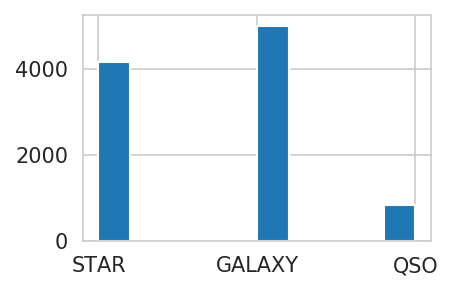

In [24]:
plt.figure(figsize=(3, 2))
# plt.pie(sdss_df['class'].value_counts(),
#         labels=sdss_df['class'].value_counts().index.values);
plt.hist(
    sdss_df['class']
         
        );

The most objects (50%) are galaxies, a little less (40%) are stars and only around (10%) of the rows are classified as QSOs.

### First Data Filtering

In [25]:
sdss_df.columns.values

array(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun',
       'camcol', 'field', 'specobjid', 'class', 'redshift', 'plate',
       'mjd', 'fiberid'], dtype=object)

There is no need to know everything about stars, galaxy or quasars - yet we can already tell which features are **unlikely** to be related to the target variable 'class'.

**objid** and **specobjid** are just identifiers for accessing the rows back when they were stored in the original databank. Therefore we will not need them for classification as they are not related to the outcome.

Even more: The features 'run', 'rerun', 'camcol' and 'field' are values which describe parts of the camera at the moment when making the observation, e.g. 'run' represents the corresponding scan which captured the oject.

Source: http://www.sdss3.org/dr9/imaging/imaging_basics.php

We will drop these columns as any correlation to the outcome would be coincidentally.

In [26]:
# drop columns 'objid', 'run', 'rerun', 'camcol', 'field', 'specobjid' from dataframe
sdss_df = sdss_df.drop(columns=['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'])

### Univariate Analysis

#### Redshift

To start the univariate analysis we will plot histograms for the 'redshift' feature column for each class.

This will tell us how the redshift values are distributed over their range.

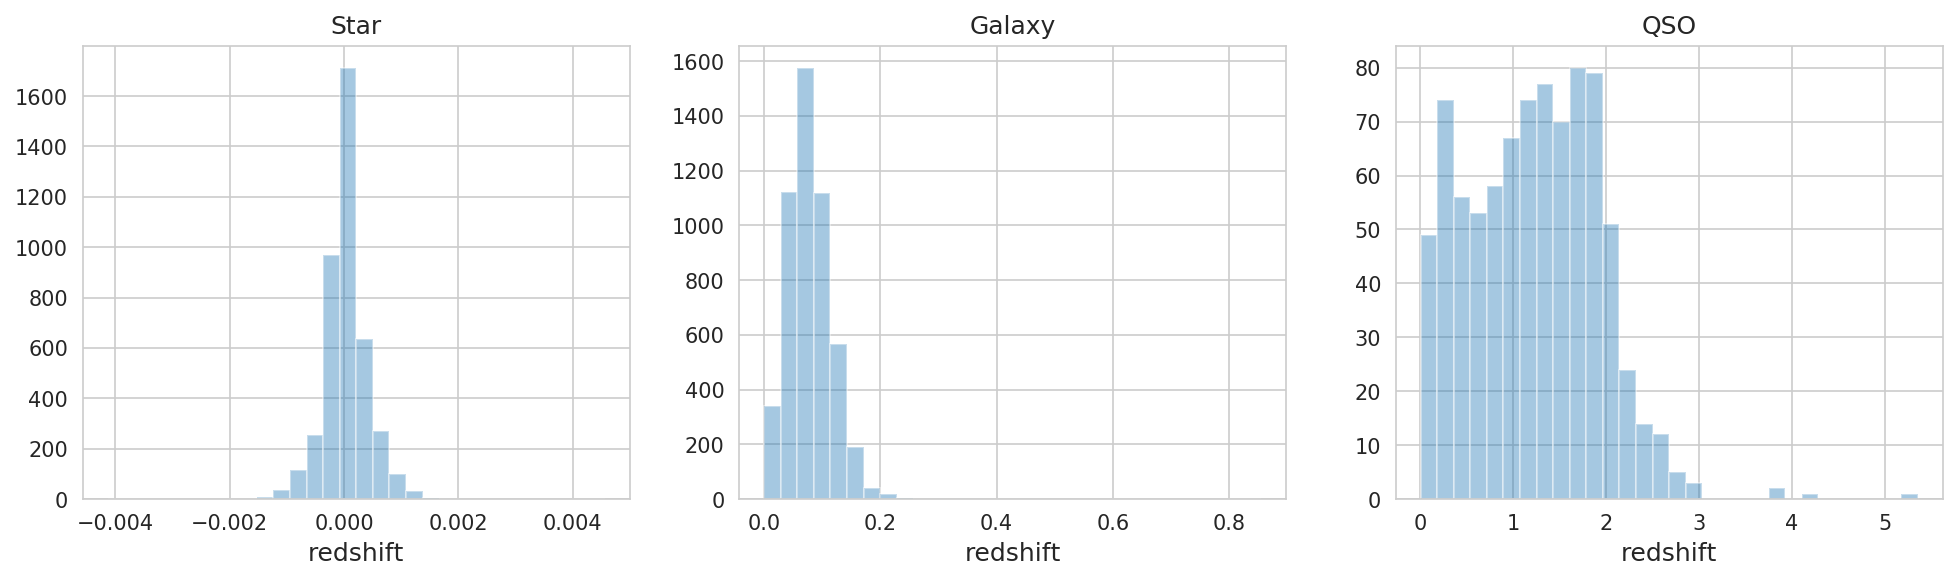

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(sdss_df[sdss_df['class']=='STAR'].redshift, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(sdss_df[sdss_df['class']=='GALAXY'].redshift, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_df[sdss_df['class']=='QSO'].redshift, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('QSO')

This is an interesting result.

We can cleary tell that the redshift values for the classes quite differ. 

* **Star:** The histogram looks like a truncated zero-centered normal distribution.

* **Galaxy:** The redshift values may come from a slightly right-shifted normal distribution which is centered around 0.075.

* **QSO:** The redshift values for QSOs are a lot more uniformly distributed than for Stars or Galaxies. They are roughly evenly distributed from 0 to 3, than the occurences decrease drastically. For 4 oder ~5.5 there are some outliers.

**The redshift can be an estimate(!) for the distance from the earth to a object in space.**

Hence the distplot tells us that most of the stars observed are somewhat closer to the earth than galaxies or quasars. Galaxies tend to be a little further away and quasars are distant from very close to very far.  

Possible rookie explanation: Since galaxies and quasars radiate stronger due to their size and physical structure, they can be observed from further away than "small" stars.

As we can distinct the classes from each other just based on this column - 'redshift' is very likely to be helping a lot classifying new objects.

#### dec

Let's lvplot the values of dec (Recall: position on celestial equator)!

Text(0.5, 1.0, 'dec')

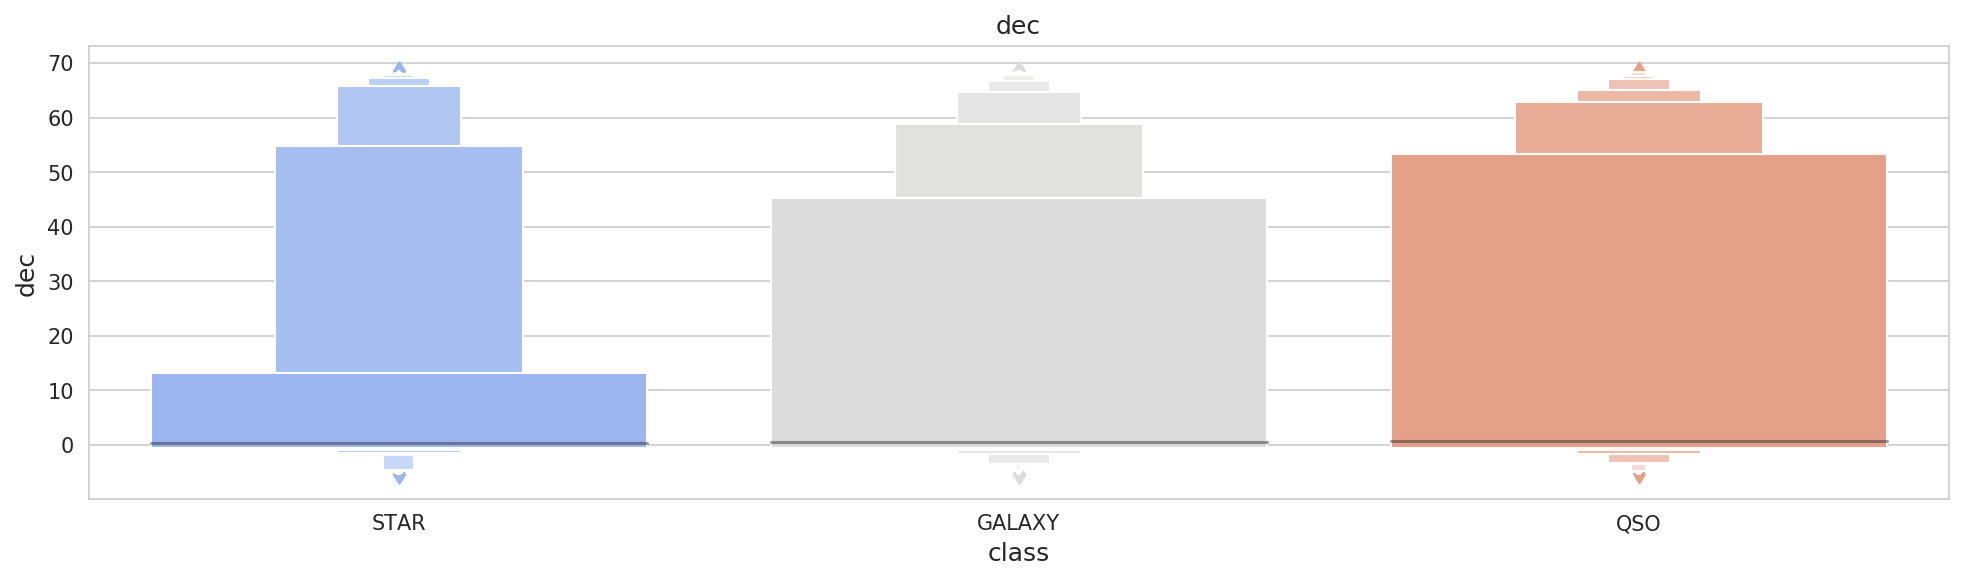

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16, 4))
ax = sns.boxenplot(x=sdss_df['class'], y=sdss_df['dec'], palette='coolwarm')
ax.set_title('dec')

**First of all: what does this plot tell us?**

The Letter value (LV) Plot show us an estimate of the distribution of the data. It shows boxes which relate to the amount of values within the range of values inside the box.

In this case we can observe a clear distinction between Stars and the other two classes. The difference between Galaxies and Quasars is smaller.

* **Star:** The largest part of the data points lay within a 0 to 10 range. Another large part consists of values between about 10 to 55. Only small amounts of the data are lower or higher than these ranges.

* **Galaxy:** The largest part of values lays between 0 and 45. There is a smaller amount of values in the range of 45 to 60. The rest of the data has smaller or higher values.

* **QSO:** This plot looks quite similiar to the GALAXY plot. Only the amount of data points in the range of 0 to 60 is even bigger.

Side Note: The fact that the distribution of dec values of galaxies und quasar objects is almost the same might indicate that one can find both galaxies and quasars at smiliar positions in the night sky.

### Multivariate Analysis

#### u,g,r,i,z filters

Recall: u, g, r, i, z represent the different wavelengths which are used to capture the observations.

Let's find out how much they are correlated.

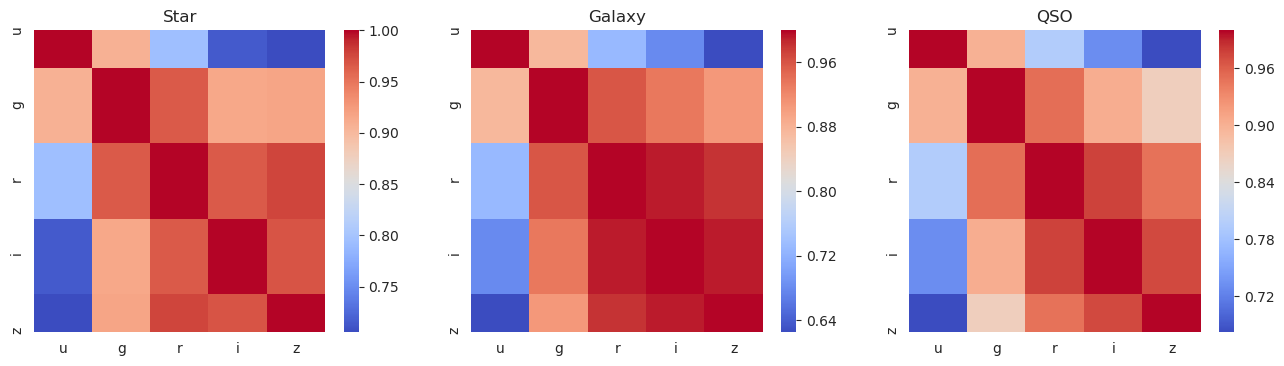

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
fig.set_dpi(100)
ax = sns.heatmap(sdss_df[sdss_df['class']=='STAR'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[0], cmap='coolwarm')
ax.set_title('Star')
ax = sns.heatmap(sdss_df[sdss_df['class']=='GALAXY'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[1], cmap='coolwarm')
ax.set_title('Galaxy')
ax = sns.heatmap(sdss_df[sdss_df['class']=='QSO'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[2], cmap='coolwarm')
ax = ax.set_title('QSO')

Right of the top we observe that the correlation matrices look very similiar for every class.

We can tell that there are high correlations between the different bands. This feels not really suprising - intuitively one would think that if one of the bands captures some object, the other bands should capture something aswell.

Therefore it is interesting to see that band 'u' is less correlated to the other bands. 

Remember: u, g, r, i, z capture light at wavelengths of 354, 476, 628, 769 and 925 nm.

This might indicates that galaxies, stars and quasar objects shine brighter at wavelengths from 476 - 925 nm. Don't quote me on that though.

**But:** as we can see - the correlation is roughly the same for every class...the different bands behave the same for the different classes!

#### Right ascension (ra) and declination (dec) 

We will now plot the right ascension versus the declination depending on the class 

Text(0.5, 1, 'Equatorial coordinates')

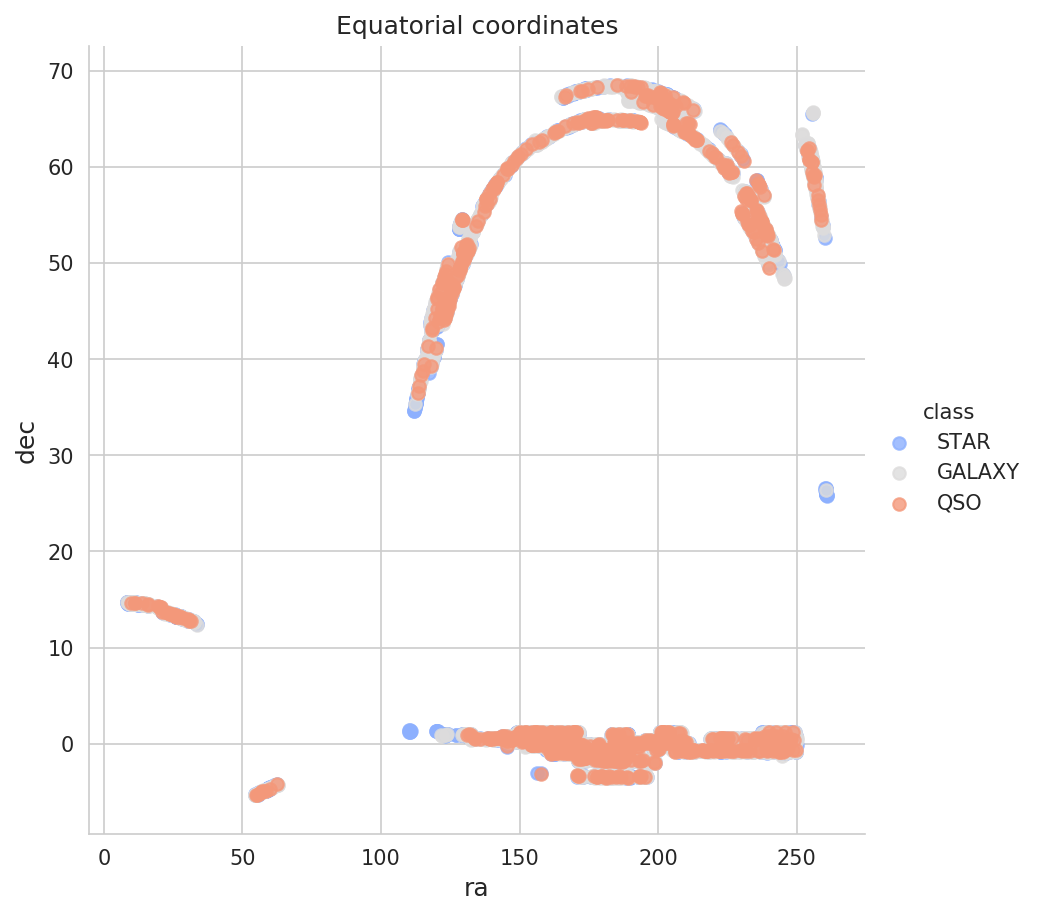

In [32]:
sns.lmplot(x='ra', y='dec', data=sdss_df, hue='class',
           fit_reg=False, palette='coolwarm', height=6, aspect=1)
plt.title('Equatorial coordinates')

As we can clearly observe the equatorial coordinates do not differ significantly between the 3 classes. There are some outliers for stars and galaxies but for the bigger part the coordinates are within the same range.

Why is that?

All SDSS images cover the same area of the sky. The plot above tells us that stars, galaxies and quasars are observed equally at all coordinates within this area. So whereever the SDSS "looks" - the chance of observing a star or galaxy or quasar is always the same.  

**This contradicts our interpretation of the letter value plot of dec from the univariate analysis.**

## Feature Engineering

### u, g, r, i, z

We will now reduce the amount of dimensions by replacing the different bands 'u', 'g', 'r', 'i' and 'z' by a linear combination with only 3 dimensions using **Principal Component Analysis**.

**Principal Component Analysis:**

n observations with p features can be interpreted as n points in a p-dimensional space. PCA aims to project this space into a q-dimensional subspace (with q<p) with as little information loss as possible. 

It does so by finding the q directions in which the n points vary the most (--> the principal components). It then projects the original data points into the q-dimensional subspace. PCA returns a n x q dimensional matrix. 

Using PCA on our data will decrease the amount of operations during training and testing.

In [34]:
sdss_df_fe = sdss_df

#### encode class labels to integers

see more [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [35]:
# create LabelEncoder object
le = LabelEncoder()

In [36]:
# transform 'class' column with LabelEcoder (see LabelEncoder().fit_transform())
sdss_df['class'] = le.fit_transform(sdss_df['class'])

In [37]:
# show classes of LabelEncoder (using LabelEncoder().classes_ object attribute)
le.classes_

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

#### Principal Component Analysis

see more [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [38]:
# initialize PCA object with 3 components (use parameter n_components)
pca = PCA(n_components=3)

In [39]:
# transform columns 'u', 'g', 'r', 'i', 'z' using PCA to get 3 dimensional vectors (from 5). 
# see PCA().fit_transform() 
ugriz = pca.fit_transform(sdss_df[['u', 'g', 'r', 'i', 'z']])

#### show transformed vectors in 3D plot

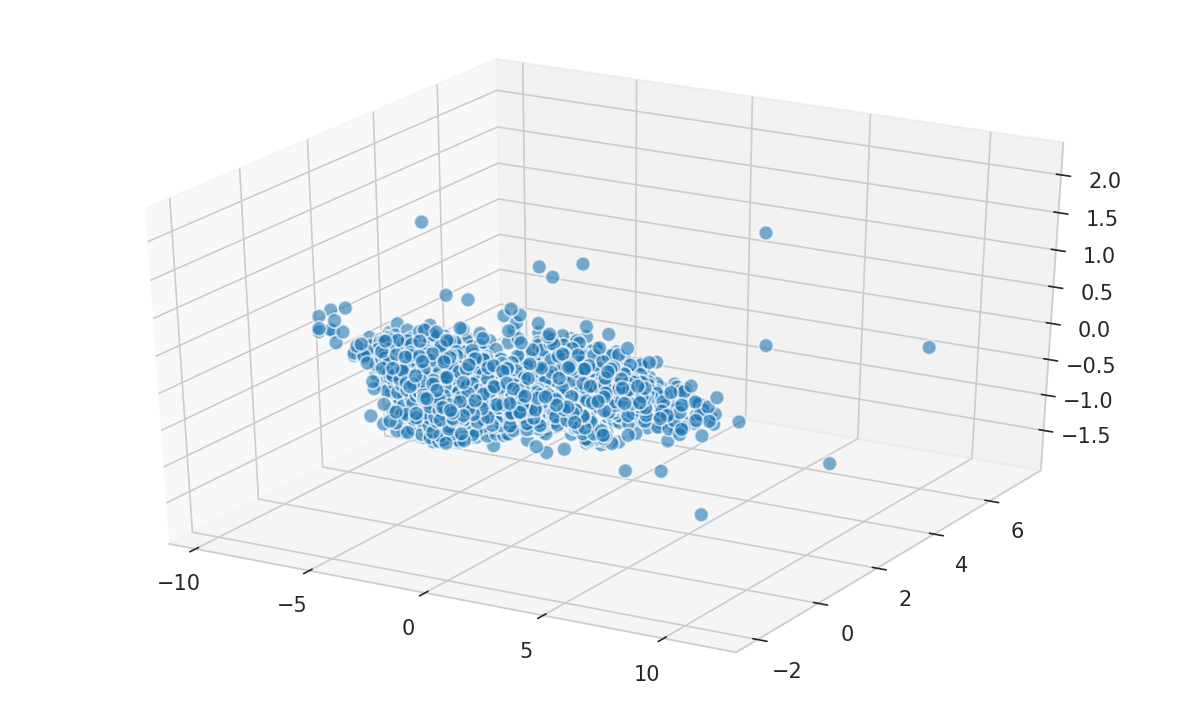

In [40]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

xs = ugriz[:,0]
ys = ugriz[:,1]
zs = ugriz[:,2]
ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')

plt.show()

#### update dataframe 

see pandas concat [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html)

In [63]:
# concatenate our dataframe and new features and then assign that dataframe back (overwrite sdss_df_fe)
sdss_df_fe = pd.concat([sdss_df, pd.DataFrame(ugriz, columns=['PCA_1','PCA_2','PCA_3'])], axis=1)
sdss_df_fe

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid,PCA_1,PCA_2,PCA_3
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,2,-0.000009,3306,54922,491,-1.507202,-1.377293,-0.265119
1,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,2,-0.000055,323,51615,541,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,0,0.123111,287,52023,513,1.297604,-0.590023,0.140338
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,2,-0.000111,3306,54922,510,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,2,0.000590,3306,54922,512,-0.849271,1.287505,-0.397689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,0,0.027583,447,51877,246,0.222959,-0.134301,-0.057857
9996,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,0,0.117772,447,51877,228,0.259171,0.415333,0.158501
9997,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,2,-0.000402,7303,57013,622,1.480725,0.388717,-0.126646
9998,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,0,0.014019,447,51877,229,1.392088,0.117004,0.038818


In [64]:
# rename columns of newly generated features. Assign columns these names: (0 -> PCA_1), (1 -> PCA_2), (2 -> PCA_3).
# hint: see pd.DataFrame().rename()
# sdss_df_fe.rename(mapper={:'PCA_1'})
sdss_df_fe

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid,PCA_1,PCA_2,PCA_3
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,2,-0.000009,3306,54922,491,-1.507202,-1.377293,-0.265119
1,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,2,-0.000055,323,51615,541,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,0,0.123111,287,52023,513,1.297604,-0.590023,0.140338
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,2,-0.000111,3306,54922,510,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,2,0.000590,3306,54922,512,-0.849271,1.287505,-0.397689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,0,0.027583,447,51877,246,0.222959,-0.134301,-0.057857
9996,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,0,0.117772,447,51877,228,0.259171,0.415333,0.158501
9997,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,2,-0.000402,7303,57013,622,1.480725,0.388717,-0.126646
9998,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,0,0.014019,447,51877,229,1.392088,0.117004,0.038818


In [65]:
# remove old columns 'u', 'g', 'r', 'i', 'z' from dataframe
# hint: see pd.DataFrame().drop()
sdss_df_fe = sdss_df_fe.drop(columns=['u', 'g', 'r', 'i', 'z'])

In [66]:
# show head of resulting dataframe
sdss_df_fe

,ra,dec,class,redshift,plate,mjd,fiberid,PCA_1,PCA_2,PCA_3
0,183.531326,0.089693,2,-0.000009,3306,54922,491,-1.507202,-1.377293,-0.265119
1,183.598371,0.135285,2,-0.000055,323,51615,541,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,0,0.123111,287,52023,513,1.297604,-0.590023,0.140338
3,183.870529,0.049911,2,-0.000111,3306,54922,510,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,2,0.000590,3306,54922,512,-0.849271,1.287505,-0.397689
...,...,...,...,...,...,...,...,...,...,...
9995,131.316413,51.539547,0,0.027583,447,51877,246,0.222959,-0.134301,-0.057857
9996,131.306083,51.671341,0,0.117772,447,51877,228,0.259171,0.415333,0.158501
9997,131.552562,51.666986,2,-0.000402,7303,57013,622,1.480725,0.388717,-0.126646
9998,131.477151,51.753068,0,0.014019,447,51877,229,1.392088,0.117004,0.038818


## Machine Learning Models - Training

#### Feature Scaling

We will now train different models on this dataset. 

Scaling all values to be within the (0, 1) interval will reduce the distortion due to exceptionally high values and make some algorithms converge faster.

see about MinMaxScaler [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [67]:
# Create MinMaxScaler object
scaler = MinMaxScaler()

In [71]:
# scale the whole dataframe using MinMaxScaler and assign it to new variable 'sdss'. 
# Warning: don't scale "class" column!.. new variable should only take input features and not target!..
# hint: see MinMaxScaler().fit_transform()
X = scaler.fit_transform(sdss_df_fe.drop(columns='class'))
y = sdss_df_fe['class']

We will  split the data into a training and a test part. The models will be trained on the training data set and tested on the test data set

In [72]:
RANDOM_STATE = 0

In [73]:
# split sdss (scaled input features - X) and target (from sdss_df_fe['class']) into train and test parts
# parameter details: test size should be 0.33, stratify using target (sdss_df_fe['class']), random_state (RANDOM_STATE)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33, stratify=y, 
                                                   random_state=RANDOM_STATE)

In [75]:
pd.concat([y_train.value_counts()/y_train.shape[0], 
           y_test.value_counts()/y_test.shape[0]], 
          axis=1, keys=['train', 'test'])

,train,test
0,0.499851,0.499697
2,0.415224,0.415152
1,0.084925,0.085152


#### Naive Bayes

Naive Bayes assumes the data to be normally distributed which can be achieved by scaling using the MaxAbsScaler. Many thanks!

see several scalers [here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)

In [76]:
from sklearn.preprocessing import MaxAbsScaler

see MaxAbsScaler also [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)

In [94]:
from sklearn.preprocessing import MinMaxScaler

# create MaxAbsScaler object here
scaler_gnb = MaxAbsScaler()
# scaler_gnb = MinMaxScaler()

In [95]:
# transform data form Naive Bayes using MaxAbsScaler and store in sdss_nb variable.
# (use sdss_df_fe data without "class" column) 
sdss_nb = scaler_gnb.fit_transform(sdss_df_fe.drop(columns='class'))

In [96]:
# split sdss_nb (scaled input features - X) and target (from sdss_df_fe['class']) into train and test parts
# parameter details: test size should be 0.33, stratify using target (sdss_df_fe['class']), random_state (RANDOM_STATE)
X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = (
    train_test_split(sdss_nb, sdss_df_fe['class'],
    stratify= sdss_df_fe['class'],
    random_state=RANDOM_STATE,
    test_size=.33)
)

In [98]:
# craate NaiveBayes object
gnb = GaussianNB()

training_start = time.perf_counter()
# fit naive bayes objext on training data (X_train_gnb, y_train_gnb)
gnb.fit(X_train_gnb,y_train_gnb)

training_end = time.perf_counter()

prediction_start = time.perf_counter()

# predict on test data (X_test_gnb)
preds = gnb.predict(X_test_gnb)
prediction_end = time.perf_counter()

acc_gnb = (preds == y_test_gnb).sum().astype(float) / len(preds)*100

gnb_train_time = training_end-training_start
gnb_prediction_time = prediction_end-prediction_start

print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: %3.2f" % (acc_gnb))
print("Time consumed for training: %4.3f seconds" % (gnb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gnb_prediction_time))
# print("AUC score is ": roc_auc_score(y_test_gnb, y_hat_gnb))

Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: 97.39
Time consumed for training: 0.007 seconds
Time consumed for prediction: 0.00262 seconds


#### XGBoost

In [99]:
# create XGBClassifier object with 100 estimators
xgb = XGBClassifier(n_estimators=100)

training_start = time.perf_counter()
# fit on training data (X_train, y_train)
xgb.fit(X_train,y_train)

training_end = time.perf_counter()

prediction_start = time.perf_counter()
# make predictions on test
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()

acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100

xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start

print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost's prediction accuracy is: 99.27
Time consumed for training: 1.478
Time consumed for prediction: 0.02419 seconds


#### Scitkit-Learn's Random Forest Classifier

In [100]:
# create RandomForestClassifier with 10 estimators
rfc = RandomForestClassifier(n_estimators=10)

training_start = time.perf_counter()
# fit on training data (X_train, y_train)
rfc.fit(X_train,y_train)
training_end = time.perf_counter()

prediction_start = time.perf_counter()
# make predictions on test data (X_test)
preds = rfc.predict(X_test)
prediction_end = time.perf_counter()

acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100

rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start

print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 98.97
Time consumed for training: 0.150 seconds
Time consumed for prediction: 0.00501 seconds


#### Support Vector Machine Classifier

In [106]:
# create support vector classifier object (SVC) with gamma='auto' parameter (to avoid some warnings - nothing important)
svc = SVC(gamma='auto',C=1000)

training_start = time.perf_counter()
# fit on training data (X_train, y_train)
svc.fit(X_train,y_train)

training_end = time.perf_counter()

prediction_start = time.perf_counter()
# make predictions on test data (X_test)
preds = svc.predict(X_test)
prediction_end = time.perf_counter()

acc_svc = (preds == y_test).sum().astype(float) / len(preds)*100

svc_train_time = training_end-training_start
svc_prediction_time = prediction_end-prediction_start

print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_svc))
print("Time consumed for training: %4.3f seconds" % (svc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svc_prediction_time))

Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 98.06
Time consumed for training: 0.686 seconds
Time consumed for prediction: 0.09437 seconds


Let's compare the results. We will create a table for a more comprehensive overview.

In [107]:
results = pd.DataFrame({
    'Model': ['Naive Bayes', 
              'XGBoost', 'Random Forest', 'SVC'],
    'Score': [acc_gnb, acc_xgb, acc_rfc, acc_svc],
    'Runtime Training': [gnb_train_time, xgb_train_time, rfc_train_time, 
                         svc_train_time],
    'Runtime Prediction': [gnb_prediction_time, xgb_prediction_time, rfc_prediction_time,
                          svc_prediction_time]})

In [108]:
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Model')

In [109]:
result_df

,Score,Runtime Training,Runtime Prediction
Model,,,
XGBoost,99.272727,1.478317,0.024192
Random Forest,98.969697,0.149657,0.005007
SVC,98.060606,0.685854,0.094370
Naive Bayes,97.393939,0.007384,0.002617


We can see that both XGBoost and Scikit-Learn's Random Forest Classifier could achieve very high accuracy.

Gaussian Naive Bayes achieves just a little less accuracy but needs a very little amount of time to both train and predict data.

The Support Vector Machine Classifier has the worst accuracy, plus takes the most of time for its operations.

### K Fold Cross Validation

We will now perform k fold cross validation for the top 2 classifiers, i.e. XGBoost & Random Forest.

We do this to get a more realistic result by testing the performance for 10 different train and test datasets and averaging the results. 

Cross validation ensures that the above result is not arbitrary and gives a more reliable performance check.

#### Scikit-Learn's Random Forest Classifier

In [110]:
from sklearn.model_selection import cross_val_score

see cross validation scorer [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [111]:
# create RandomForestClassifier with 100 estimators
rfc_cv = RandomForestClassifier(n_estimators=100)
# calcualte cross validation scores on training data (X_train, y_train), use cv=10 to create 10 folds 
# use "accuracy" for scoring  
scores = cross_val_score(rfc_cv,X_train,y_train,cv=10)
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.98956781 0.99552906 0.99104478 0.99552239 0.99552239 0.99104478
 0.98955224 0.99253731 0.98955224 0.99550898]
Mean: 0.9925381971781686
Standard Deviation: 0.002582582682604831


#### XGBoost

In [112]:
# create XGBClassifier object with 100 estimators
xgb_cv = XGBClassifier(n_estimators=100)
# calcualte cross validation scores on training data (X_train, y_train), use cv=10 to create 10 folds 
# use "accuracy" for scoring 
scores = cross_val_score(xgb_cv,X_train,y_train,cv=10)
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.99403875 0.99254844 0.99104478 0.99850746 0.99253731 0.99552239
 0.99402985 0.99402985 0.99253731 0.99700599]
Mean: 0.9941802126556327
Standard Deviation: 0.0021556590509317305


Cross validating the models showed that the accuracy values were in fact not arbitary and proofed that both models are performing very well. 

**Mean** corresponds to a stable performance and a **standard deviation** corresponds to range of results (scores).
The higher the mean and the lower the standard deviation the better is our model.

### Feature Importance

Decision Trees have the unique property of being able to order features by their ability to split between the classes.

We will now visualize the features and their splitting ability.

see more about feature importances in xgboost [here](https://xgboost.readthedocs.io/en/latest/R-package/discoverYourData.html)

In [113]:
importances = pd.DataFrame({
    'Feature': sdss_df_fe.drop('class', axis=1).columns,
    'Importance': xgb.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=True)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
dec,0.004687
ra,0.007736
PCA_2,0.008929
fiberid,0.010218
plate,0.010669
mjd,0.013720
PCA_1,0.024975
PCA_3,0.031311
redshift,0.887755


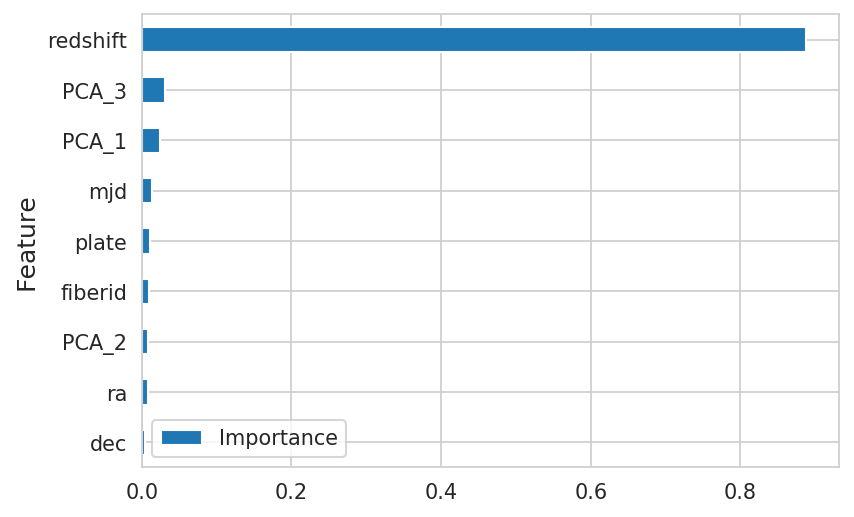

In [114]:
importances.plot.barh();

Here we can clearly see how PCA helped to improve the performance of our predictors as 2 of the principal components are in the top 3 features.

The best (in terms of being able to split classes) is redshift.

Let's drop the column from the dataframe and rescale it. Since XGBoost requires the class to be discrete, we will re-add it manually afterwards.

### We can drop non-important features here

let's drop lats two features `ra` and `dec`

In [115]:
# create MinMaxScaler object
scaler = MinMaxScaler()

In [119]:
# store two least important columns (considering feature importances)
remove_cols = ['ra','dec']

In [120]:
sdss = pd.DataFrame(scaler.fit_transform(sdss_df_fe.drop(remove_cols + ['class'], axis=1)),
                    columns=sdss_df_fe.drop(remove_cols + ['class'], axis=1).columns)
sdss['class'] = sdss_df_fe['class']

In [121]:
sdss.head()

,redshift,plate,mjd,fiberid,PCA_1,PCA_2,PCA_3,class
0,0.000770,0.373281,0.566492,0.490490,0.385886,0.069348,0.387685,2
1,0.000762,0.006999,0.006268,0.540541,0.448110,0.215264,0.415556,2
2,0.023749,0.002579,0.075385,0.512513,0.518964,0.154511,0.490959,0
3,0.000751,0.373281,0.566492,0.509510,0.388785,0.279638,0.452852,2
4,0.000882,0.373281,0.566492,0.511512,0.417103,0.357613,0.353918,2


### Summary

We trained different machine learning models to solve this classification problems. Without any further hyperparameter tuning XGBoost and Scikit-Learn's Random Forest Classifier performed the best.

As XGBoost showed a little higher accuracy in most of the tests, we will continue only with this classifier.

## XGBoost - Finding the best hyperparameters

Now it's time to look for the optimal hyperparameters - what does this mean?

We will test our chosen model with different values for (almost) each of its tuning parameters and give back the parameters with which the model performed best.

**The actual searching for optimal parameters is not done in this notebook since the operations can take some time and parallel editing would not be possible.

The best parameters for prediction as found by the tuning tests are:

- max_depth = 5
- min_child_weight = 1
- gamma = 0
- subsample = 0.8
- colsample_bytree = 0.8
- reg_alpha = 0.005

## XGBoost - Testing optimal hyperparameters

The following model implements the best performing model with optimal parameters evaluated by the hyperparameter tuning. We will expect the model to perform even better than before.

Analytics Vidhya presented a really nice guide for tuning XGBoost. 

Please read more: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [122]:
# split sdss (scaled input features - X) and target (from sdss['class']) into train and test parts
# parameter details: test size should be 0.33, stratify using target (sdss['class']), random_state (RANDOM_STATE)
X_train, X_test, y_train, y_test = train_test_split(X, sdss['class'], test_size=.33, stratify=sdss['class'],
                                                   random_state=RANDOM_STATE)

In [123]:
# create XGBClassifier object with given parameters:
# maximum tree depth = 5
# learning rate = 0.001
# number of estimators = 100
# gamma = 0
# minimum child weight = 1
# subsample = 0.8
# colsample by tree = 0.8
# reg alpha = 0.005
xgboost = XGBClassifier(
    max_depth=5,
    n_estimators=100,
    gamma=0,
    min_child_weight=1,
    subsample=.8,
    colsample_bytree=.8,
    reg_alpha=.005
)

In [124]:
# fit model on training data
xgboost.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [125]:
# make predictions on test data
preds = xgboost.predict(X_test)

In [126]:
accuracy = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy WITH optimal hyperparameters is: %3.2f" % (accuracy))

XGBoost's prediction accuracy WITH optimal hyperparameters is: 99.24


The parameter tuning did not improve the accuracy as excpected. We will therefore do a cross validation to test to get a more reliable result.

In [130]:
# create new XGBClassifier object for cross validation with 100 estimators
xgb_cv = XGBClassifier(n_estimators=100)

In [132]:
# cross validate on training data with "accuracy" scoring (see previous examples to recap)
scores = cross_val_score(xgb_cv, X_train,y_train, scoring='accuracy',cv=10)

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.99403875 0.99254844 0.99104478 0.99850746 0.99253731 0.99552239
 0.99402985 0.99402985 0.99253731 0.99700599]
Mean: 0.9941802126556327
Standard Deviation: 0.0021556590509317305


Depending on the run the cross validation results vary from a little lower and a little better than before. 

This indicates that the parameter tuning was not as effective as expected - this could mean that XGBoost was actually close to its maximum performance capability on this data set.

As we still have a good performance we will now continue with further evaluation of the performance of our model!

## XGBoost - Evaluation

### Confusion Matrix

In [135]:
unique, counts = np.unique(sdss['class'], return_counts=True)
dict(zip(unique, counts))

{0: 4998, 1: 850, 2: 4152}

see how cross validated prediction works [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)

In [ ]:
# use cross val predict to predict results using xgb model object on sdss data (train+test)
# pass xgb as model
# pass sdss without "class" column as X
# pass sdss "class" column as Y
# use cross validation = 3 (cv=3)

predictions = cross_val_predict(xgb, sdss.drop['class'])

In [ ]:
confusion_matrix(sdss['class'], predictions)

The first row shows that out of 4998 stars, **4964 were classified correctly as stars**. 26 stars were classified incorrectly as galaxies and 8 stars were classified incorrectly as quasars.

The second row shows out of 850 quasars **826 were classified correctly**. 23 quasars were classified incorrectly as stars and 1 quasar was classified as galaxy.

The last row tells us that out of 4152 galaxies **4146 were classified correctly.**. 6 galaxies were classified incorrectly as star.

In total: 

We have only 64 objects which were classified incorrectly. Most of the objects were recognized as what they are.

### Precision & Recall

for micro and macro averaging see short information [here](https://sebastianraschka.com/faq/docs/multiclass-metric.html) 

In [ ]:
print("Precision:", precision_score(sdss['class'], predictions, average='micro'))
print("Recall:",recall_score(sdss['class'], predictions, average='micro'))

In [ ]:
print("Precision:", precision_score(sdss['class'], predictions, average='macro'))
print("Recall:",recall_score(sdss['class'], predictions, average='macro'))

Precision is the fraction of events where the algorithm classified an object of type **t** correctly out of all occurences of the algorithm classifying objects of type **t**.

Recall is the fraction of events where the algorithm classified an object of type **t** correctly when the true type of that object was actually **t**.

Precision in our case:

For every class its calculated how many objects were classified as stars (or galaxies or quasars) in relation to the amount of correct star (or galaxies or quasars) predictions. The results are averaged --> 99.36%.

Recall in our case:

For every class its calculated how many objects were classified as stars (or galaxies or quasars) in relation to the total amount of predictions where the object actually was a star (or galaxy or quasar). The results are averaged --> 99.36%.

In both cases our algorithm did a very good job. The highest precision or recall value a predictor can have is 1.0.

### F1-Score

One can combine precision and recall into one score, which is called the F-score. The F-score is computed with the harmonic mean of precision and recall. Note that it assigns much more weight to low values. As a result of that, the classifier will only get a high F-score, if both recall and precision are high.

for micro and macro averaging see short information [here](https://sebastianraschka.com/faq/docs/multiclass-metric.html) 

In [133]:
print("F1-Score:", f1_score(sdss['class'], predictions, average='micro'))

NameError: name 'predictions' is not defined

In [134]:
print("F1-Score:", f1_score(sdss['class'], predictions, average='macro'))

NameError: name 'predictions' is not defined

As precision and recall have the same value the F1-Score has automatically the same value too. Again, we are very close to 1.0 which indicates strong performance.

## Summary

In this notebook we get data from the SDSS, analyze the data (we learned some very interesting facts about our space along the way), how to build a machine learning model to predict for unseen data from this data set and how to improve its performance (even though there was only a slight improvent).
We used XGBoost for predicting and evaluated its result.